In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os, gym, json
from utils import DTRPOCore as Core
from algorithm.dtrpo import DTRPO
from utils.various import *
from utils.delays import DelayWrapper


In [2]:
stoch_MDP = True
delay_proba = 0.7
max_delay = 50
stochastic_delays = False
delay = 3
env_name = 'Pendulum'
save_dir = r'C:\Users\pierr\Desktop\Polimi\delay_mdp\dmdp\output\dtrpo\Pendulum-Results\Pendulum-run24'
epoch = 100

In [3]:
env = gym.make(env_name + '-v0')
# Add the delay wrapper
env = DelayWrapper(env, delay=delay, stochastic_delays=stochastic_delays, p_delay=delay_proba, max_delay=max_delay)


save_model = next(filter(lambda x: '.pt' in x, os.listdir(save_dir)))
load_parameters = os.path.join(save_dir,'model_parameters.txt')
with open(load_parameters) as text_file:
    file_args = json.load(text_file)

# Policy and belief module parameters 
ac_kwargs = dict(
    pi_hidden_sizes=[file_args['pi_hid']] * file_args['pi_l'],
    v_hidden_sizes=[file_args['v_hid']] * file_args['v_l'],
    enc_dim=file_args['enc_dim'], enc_heads=file_args['enc_heads'], enc_ff=file_args['enc_ff'],
    enc_l=file_args['enc_l'], enc_rescaling=file_args['enc_rescaling'], enc_causal=file_args['enc_causal'],
    pred_to_pi=file_args['enc_pred_to_pi'], hidden_dim=file_args['hidden_dim'], n_blocks_maf=file_args['n_blocks_maf'], 
    hidden_dim_maf=file_args['hidden_dim_maf'], lstm=file_args['lstm'], n_layers=file_args['n_layers'],
    hidden_size=file_args['hidden_size']
)

dtrpo = DTRPO(env, actor_critic=Core.TRNActorCritic, ac_kwargs=ac_kwargs, seed=0,
              save_dir=save_dir, stoch_env=stoch_MDP)



 Number of parameters: 	 pi: 4802, 	 v: 641, 	 enc: 3916



In [46]:
dtrpo.load_session(epoch)
dtrpo.ac.enc.eval()
dtrpo.ac.pi.eval()
o = dtrpo.env.reset()

if isinstance(dtrpo.env.action_space, Discrete):
    temp_o = torch.tensor([i % dtrpo.act_dim == o[1][i // dtrpo.act_dim]
                           for i in range(dtrpo.act_dim * len(o[1]))]).float()
    o = torch.cat((torch.tensor(o[0]), temp_o.reshape(-1)))
else: 
    o = torch.cat((torch.tensor(o[0]), torch.tensor(o[1]).reshape(-1)))

o = torch.as_tensor(o, dtype=torch.float32).unsqueeze(dim=0)


(array([-0.99398978, -0.10947289,  0.20532147]), array([[ 1.6290894 ],
       [-0.61107403],
       [-0.02132395]], dtype=float32))
tensor([[-0.9940, -0.1095,  0.2053,  1.6291, -0.6111, -0.0213]])


In [41]:
print('State: \t\t{0} \nActions: \t{1}'.format(o[0,:3],o[0,3:]))

State: 		tensor([-1.0000e+00, -1.3526e-04, -4.6938e-01]) 
Actions: 	tensor([0., 0., 0.])


torch.Size([100, 3, 3])


[]

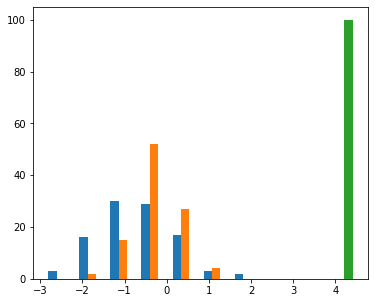

In [31]:
num_samples = 100
with torch.no_grad():
        cond = dtrpo.ac.enc.get_cond(o).detach()
cond = cond.repeat(num_samples,1,1)

dtrpo.ac.enc.maf_proba.num_inputs = 1
samples = dtrpo.ac.enc.maf_proba.sample(num_samples=num_samples, cond_inputs=cond)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.hist(samples[:,-1,:].detach().numpy())
plt.plot()